### Setup

In [ ]:
!pip install -U gym

In [ ]:
import gym
import seaborn as sns
import numpy as np

# Set seaborn plotting type
sns.set(rc={'figure.figsize':(14, 10)})

import random
import time
from IPython.display import clear_output

### Create taxi env

In [ ]:
env = gym.make('Taxi-v3')
env.seed(42)


### Parametrii

In [ ]:
LOG_INTERVAL = 100 #@param {type: "slider", min: 0, max: 1000, step: 10}
NR_EPISODES = 5 #@param {type: "slider", min: 5, max: 10000, step: 5}

### Hyperparametrii

In [18]:
ALPHA = 0.1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}
GAMMA = 0.9 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}
EPSILON = 0.2 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}

DECAY = True #@param {type: "boolean"}
DECAY_EPS_UP = 0.6 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.05}
DECAY_EPS_DOWN = 0.1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.05}
DECAY_EPS_EPISODES = 100 #@param {type: "slider", min: 0, max: 10000, step: 5}


In [19]:
def choose_action(Q: np.array, state: int, eps: float = 0.0) -> int:
    if random.uniform(0, 1) < eps:
        return random.choice(np.arange(len(Q[state])))
    else:
        return np.argmax(Q[state])

### Q-Learning

$$
  Q[s_t, a] = Q[s_t, a] + \alpha(R + \gamma \max_{a}Q[s_{t+1}, a] - Q[s_t, a])
$$


In [20]:
def q_learning(eps: float, 
               decay_eps_down: float or None, 
               decay_eps_up: float or None, 
               alpha: float,
               gamma: float,
               num_episodes: int,
               verbose: bool = False,
               non_reward: bool = False):
    REWARDS = []

    # Table used to keep the utilities for state-action
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for i in range(1, num_episodes + 1):
        state = env.reset()
        has_ended = False
        total_reward = 0
      
        decay_rate = max([(num_episodes - i) / num_episodes, 0]) 
        while not has_ended:
            if DECAY:
                action = choose_action(Q, state, (decay_eps_up - decay_eps_down) * decay_rate + decay_eps_down)
            else:
                action = choose_action(Q, state, eps)
          
            # Do the action
            next_state, reward, has_ended, _ = env.step(action)

            # Cumulate the reward for plotting
            if non_reward:
                if reward != -1:
                    total_reward += reward
            else:    
                total_reward += reward

            # Update the Q(state, action) with the new value
            Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward + gamma * max(Q[next_state]))

            # Go to the new state
            state = next_state

        if i % LOG_INTERVAL == 0:
            REWARDS.append(total_reward)
            if verbose:
                print(f"Episode: {i}")
            

    Q_1 = Q
    print("Training Q-Learning finished.\n")
    return Q, REWARDS

#### Let's check the driver

In [21]:
state = env.reset()
has_ended = False
DECAY = False

Q, REWARDS = q_learning(EPSILON, None, None, ALPHA, GAMMA, 10000)

# while not has_ended:
#     action = choose_action(Q, state)
#     state, reward, has_ended, _ = env.step(action)
#     time.sleep(1.0)
#     env.render()
#     print(f"Reward {reward}")
#     clear_output(wait=True)

Training Q-Learning finished.



### And the rewards

Training Q-Learning finished.

Training Q-Learning finished.



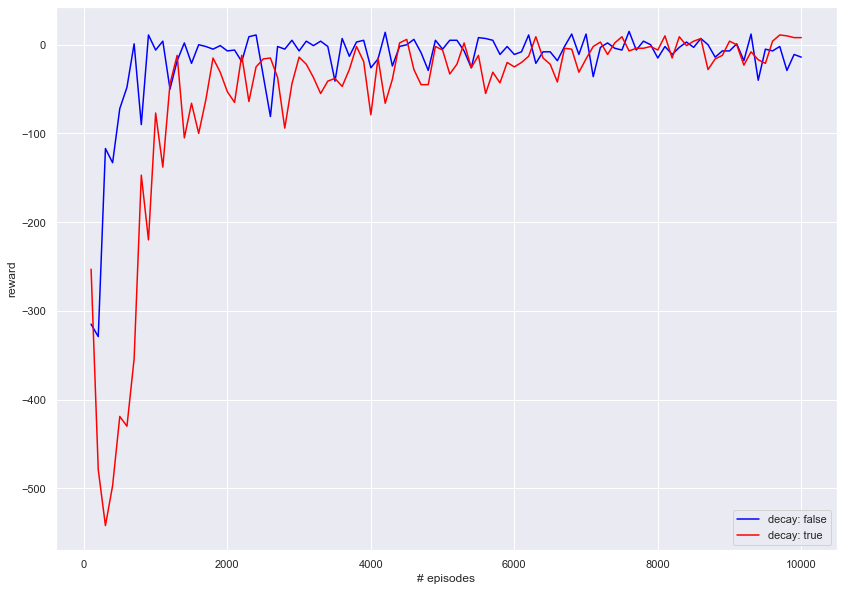

In [22]:
DECAY = False
Q, REWARDS = q_learning(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)
DECAY = True
_Q, _REWARDS = q_learning(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="decay: false")

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = _REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='red', label="decay: true")

plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

### SARSA 


$$
  Q[s_t, a] = Q[s_t, a] + \alpha(R + \gamma Q[s_{t+1}, a'] - Q[s_t, a])
$$


In [23]:
def sarsa(eps: float, 
          decay_eps_down: float or None, 
          decay_eps_up: float or None, 
          alpha: float,
          gamma: float,
          num_episodes: int,
          verbose: bool = False,
          non_reward: bool = False):
  
    REWARDS = []

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for i in range(1, num_episodes + 1):
        state = env.reset()
        has_ended = False
        total_reward = 0

        # Get the action
        decay_rate = max([(num_episodes - i) / num_episodes, 0])

        if DECAY:
            action = choose_action(Q, state, (decay_eps_up - decay_eps_down) * decay_rate + decay_eps_down)
        else:
            action = choose_action(Q, state, eps)

        while not has_ended:
            # Do the action
            next_state, reward, has_ended, _ = env.step(action)

            # Get the next_action from the next_state
            if DECAY:
                next_action = choose_action(Q, state, (decay_eps_up - decay_eps_down) * decay_rate + decay_eps_down)
            else:
                next_action = choose_action(Q, next_state, eps)

            # Cumulate the reward for plotting
            if non_reward:
                if reward != -1: # illegal action is targeted with -1 by default
                    total_reward += reward
            else:    
                total_reward += reward

            # Update the Q(state, action) with the new value
            Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward + gamma * Q[next_state][next_action])

            # Go to the new state
            state = next_state

            # Update the action
            action = next_action

        
        if i % LOG_INTERVAL == 0:
            REWARDS.append(total_reward)
            if verbose:
                print(f"Episode: {i}")

    Q_2 = Q
    print("Training SARSA finished.\n")
    return Q, REWARDS
  

#### Let's check the driver

In [24]:
state = env.reset()
has_ended = False
DECAY = False

Q, REWARDS = sarsa(EPSILON, None, None, ALPHA, GAMMA, 10000)

# while not has_ended:
#     action = choose_action(Q, state)
#     state, reward, has_ended, _ = env.step(action)
#     time.sleep(0.75)
#     env.render()
#     print(f"Reward {reward}")
#     clear_output(wait=True)

Training SARSA finished.



#### And the rewards

Training SARSA finished.

Training SARSA finished.



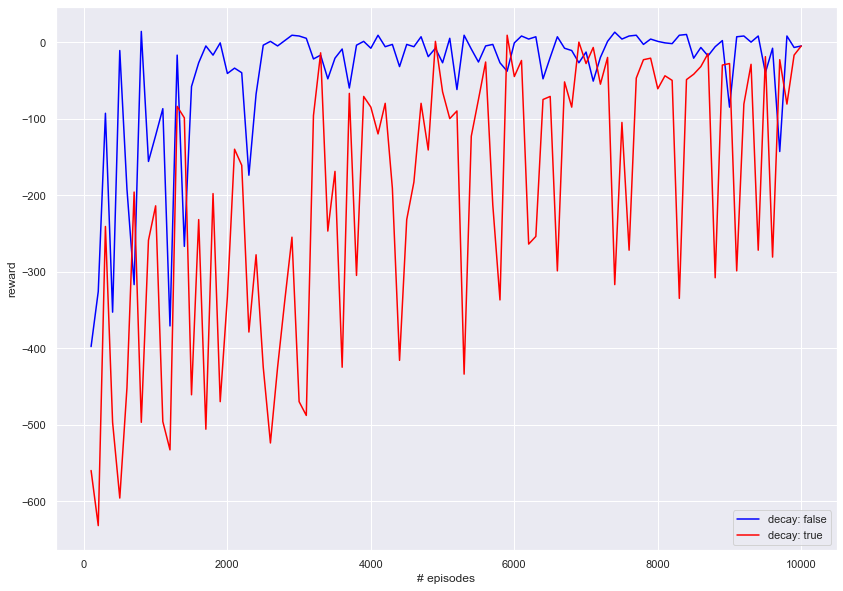

In [25]:
DECAY = False
Q, REWARDS = sarsa(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)
DECAY = True
_Q, _REWARDS = sarsa(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="decay: false")

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = _REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='red', label="decay: true")

plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

### Results for different parameters

Parameters grid search. The code below was used to generate 4 configuration files for wach type of algorithm and each type of policy. The files are attached in the archive. 

In [26]:
# Generate variations for hyperparameters
def generator():
    _step = 0.1
    alpha = (0.1, 0.6) # min, max values
    gamma = (0.5, 1.0)  
    eps = (0.1, 1.0) 
    _decay_eps_step = 0.05
    decay_eps_down = (0.1, 0.5)
    decay_eps_up = 0.95 

    num_episodes = (2000, 10000)
    _step_episodes = 2000

    params = []
    if not DECAY:
        for _num_episodes in range(num_episodes[0], num_episodes[1], _step_episodes):
            for _alpha in np.arange(alpha[0], alpha[1], _step):
                for _gamma in np.arange(gamma[0], gamma[1], _step):
                    for _eps in np.arange(eps[0], eps[1], _step):
                        
                        _params = {
                              "num_episodes": _num_episodes,
                              "alpha": _alpha,
                              "gamma": _gamma,
                              "eps": _eps
                          }
                        
                        params.append(_params)
    else:
        for _num_episodes in range(num_episodes[0], num_episodes[1], _step_episodes):
            for _alpha in np.arange(alpha[0], alpha[1], _step):
                for _gamma in np.arange(gamma[0], gamma[1], _step):
                    for _decay_eps_down in np.arange(_decay_eps_down[0], _decay_eps_down[1], _decay_eps_step):
                        _params = {
                              "num_episodes": _num_episodes,
                              "alpha": _alpha,
                              "gamma": _gamma,
                              "decay_eps_down": _decay_eps_down,
                              "decay_eps_up": decay_eps_up
                          }

                        params.append(_params)

    return params 

In [27]:
DECAY = False
params_grid = generator()
print(len(params_grid))

900


In [28]:
print('Start experimenting for: {} variations (standard version)'.format(len(params_grid)))
QR_qlearning_no_decay = {}

for params in params_grid[899:]:
    alpha = params['alpha']
    gamma = params['gamma']
    num_episodes = params['num_episodes']
    eps = params['eps']

    _Q, _R = q_learning(eps, None, None, alpha, gamma, num_episodes)
    QR_qlearning_no_decay[str(params)] = sum(_R)
QR_qlearning_sorted = dict(sorted(QR_qlearning_no_decay.items(), key=lambda item: item))
print(QR_qlearning_sorted)

Start experimenting for: 900 variations (standard version)
Training Q-Learning finished.

{"{'num_episodes': 8000, 'alpha': 0.5, 'gamma': 0.8999999999999999, 'eps': 0.9}": -41898}


In [29]:
import json
# Get top 5 with increasing reward
current_plot = 0
sns.set_palette("Paired")

for cfg in QR_qlearning_sorted:
    if current_plot == 5:
        break
    
    num_episodes = QR_qlearning_sorted[cfg][2]
    R = QR_qlearning_sorted[cfg][1]
    x_points = np.arange(LOG_INTERVAL, num_episodes + 1, LOG_INTERVAL)
    y_points = R
    plt = sns.lineplot(x=x_points, y=y_points)
    plt.set(xlabel="# episodes", ylabel="reward", label=cfg)
    current_plot += 1
    

TypeError: 'int' object is not subscriptable

Training Q-Learning finished.

Training Q-Learning finished.



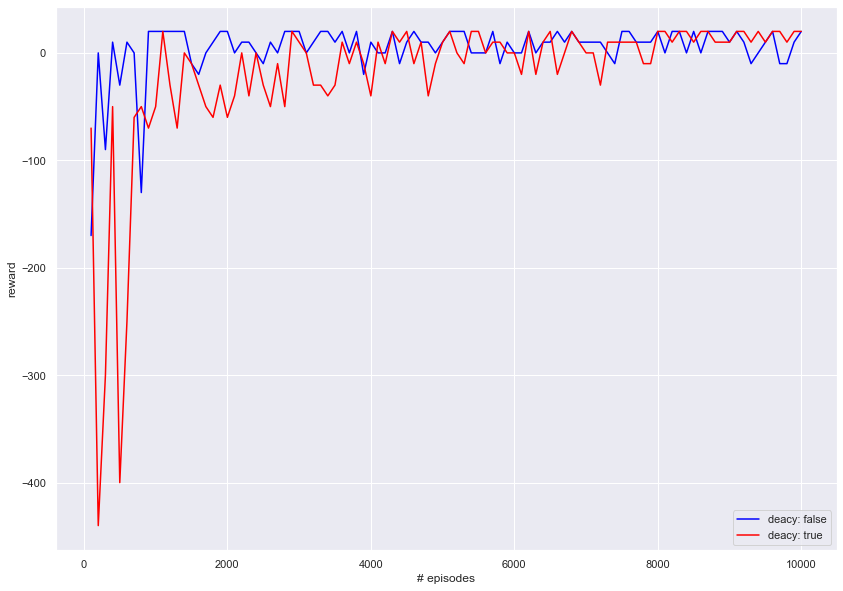

In [30]:
# Just call with non_reward = True
DECAY = False
Q, REWARDS = q_learning(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000, non_reward = True)
DECAY = True
_Q, _REWARDS = q_learning(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000, non_reward = True)

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="deacy: false")

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = _REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='red', label="deacy: true")

plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

Training SARSA finished.

Training SARSA finished.



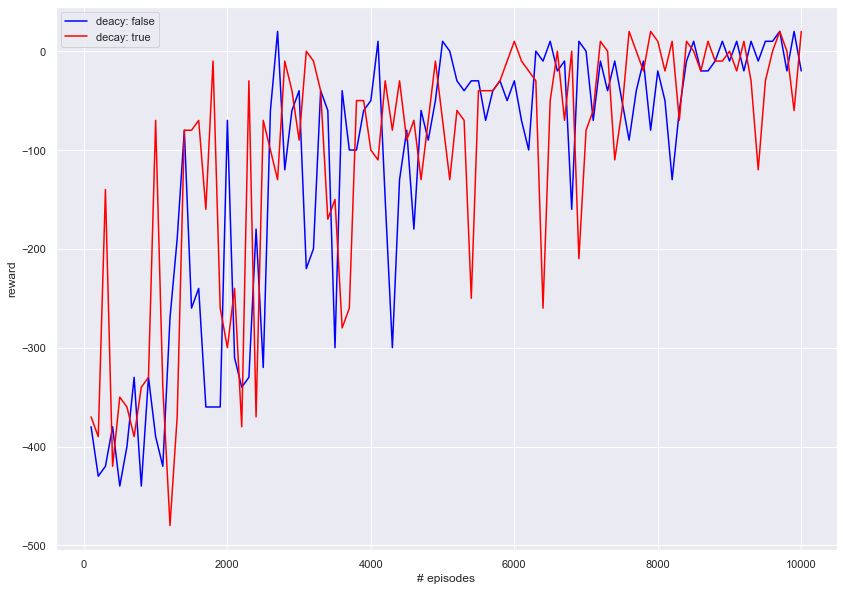

In [31]:
ECAY = False
Q, REWARDS = sarsa(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000, non_reward = True)
DECAY = True
_Q, _REWARDS = sarsa(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000, non_reward = True)

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color="blue", label="deacy: false")

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = _REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color="red", label="decay: true")

plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

Training Q-Learning finished.

Training Q-Learning finished.



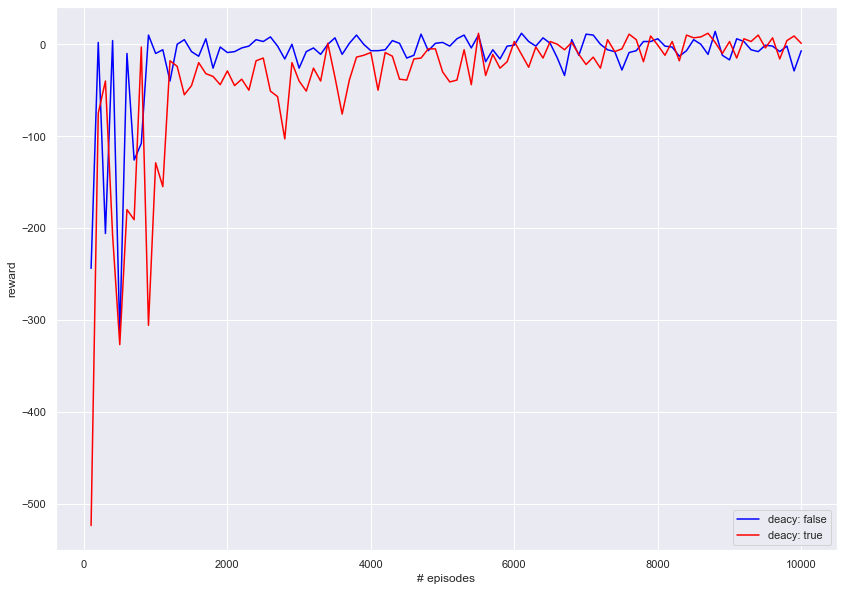

In [32]:
DECAY = False
Q, REWARDS = q_learning(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)
DECAY = True
_Q, _REWARDS = q_learning(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="deacy: false")

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = _REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='red', label="deacy: true")

plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

Training SARSA finished.

Training SARSA finished.



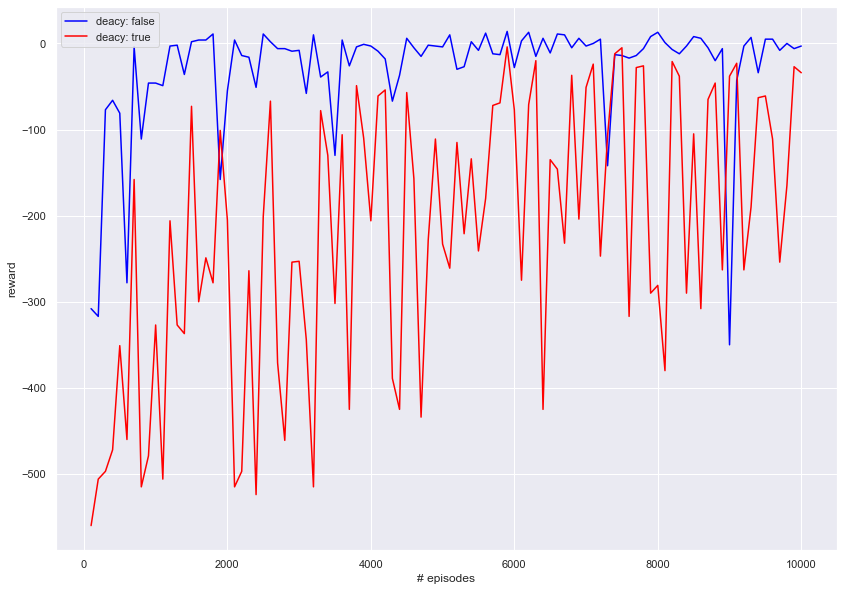

In [33]:
DECAY = False
Q, REWARDS = sarsa(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)
DECAY = True
_Q, _REWARDS = sarsa(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 10000)

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="deacy: false")

x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
y_points = _REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='red', label="deacy: true")

plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

# Q learning vs SARSA

Training Q-Learning finished.

Training SARSA finished.



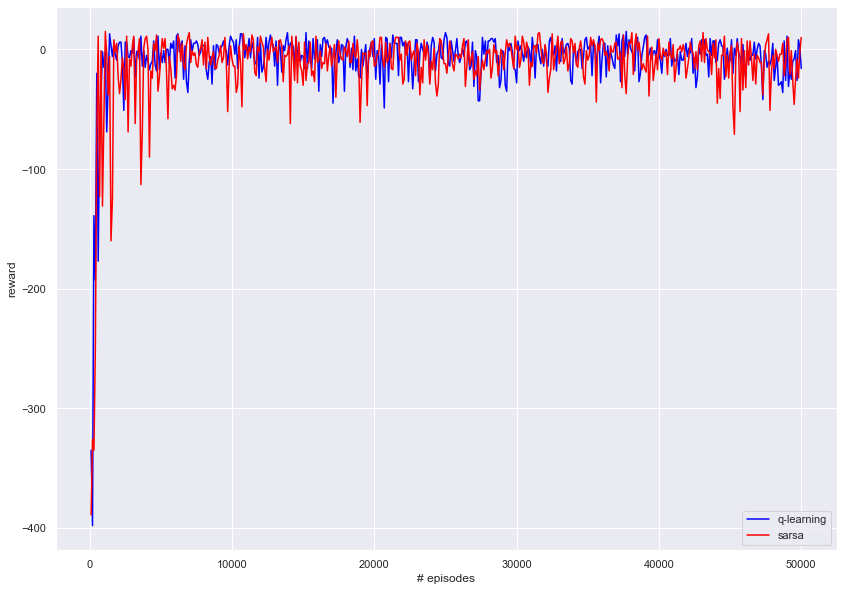

In [34]:
DECAY = False
Q, REWARDS = q_learning(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 50000)
DECAY = False
_Q, _REWARDS = sarsa(EPSILON, DECAY_EPS_DOWN, DECAY_EPS_UP, ALPHA, GAMMA, 50000)

x_points = np.arange(LOG_INTERVAL, 50000 + 1, LOG_INTERVAL)
y_points = REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="q-learning")

x_points = np.arange(LOG_INTERVAL, 50000 + 1, LOG_INTERVAL)
y_points = _REWARDS
plt = sns.lineplot(x=x_points, y=y_points, color='red', label="sarsa")

plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

## Testing for lab 5 values

Training Q-Learning finished.

Training SARSA finished.

Training Q-Learning finished.

Training SARSA finished.

Training Q-Learning finished.

Training SARSA finished.

Training Q-Learning finished.

Training SARSA finished.

Training Q-Learning finished.

Training SARSA finished.

Training Q-Learning finished.

Training SARSA finished.



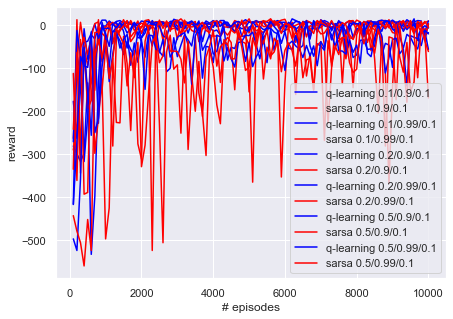

In [36]:
sns.set(rc={'figure.figsize':(7, 5)})

for eps in [0.1, 0.2, 0.5]:
    for gamma in [0.9, 0.99]:
        for alpha in [0.1, 0.2, 0.9]:
            DECAY = False
            Q, REWARDS = q_learning(eps, DECAY_EPS_DOWN, DECAY_EPS_UP, alpha, gamma, 10000)
            DECAY = False
            _Q, _REWARDS = sarsa(eps, DECAY_EPS_DOWN, DECAY_EPS_UP, alpha, gamma, 10000)

            x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
            y_points = REWARDS
            plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="q-learning {}/{}/{}".format(eps, gamma, alpha))

            x_points = np.arange(LOG_INTERVAL, 10000 + 1, LOG_INTERVAL)
            y_points = _REWARDS
            plt = sns.lineplot(x=x_points, y=y_points, color='red', label="sarsa {}/{}/{}".format(eps, gamma, alpha))

            plt.set(xlabel="# episodes", ylabel="reward")
            plt.legend()
            break
            